In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
%matplotlib inline

os.chdir('..\..\..\..')
print(os.getcwd())

from input_configuration import base_year

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


C:\workspace\sc_18_bike_count_test


In [2]:
working_dir = r'outputs/agg/dash'
# pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///inputs/db/soundcast_inputs.db',
        columns=['CountyName','ParcelID'])

# Usual School Distance

In [5]:
person = pd.read_csv(r'outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pspcl', right_on='ParcelID', how='left')

In [7]:
person['wt_psautime'] = person['psautime']*person['psexpfac']
person['wt_psaudist'] = person['psaudist']*person['psexpfac']

Average Distance for **All Workers** Not Working at Home (weighted for survey)

In [8]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     4.214221
survey    4.987551
dtype: float64

Average Distance by Work County

In [9]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.125767,5.215412
Kitsap,3.443082,4.751304
Pierce,4.461954,4.840201
Snohomish,3.934793,4.830097


Average for **Full-Time** Students only

In [11]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pstyp'] == 1)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     4.214221
survey    3.633984
dtype: float64

In [14]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.125767,4.020363
Kitsap,3.443082,6.302522
Pierce,4.461954,3.546195
Snohomish,3.934793,2.585259


Average for **Part-Time** Students Only

In [15]:
df = person[(person['pstaz'] > 0) & (person['psaudist'] > 0) & (person['pstyp'] == 1)]
df.groupby('source').sum()['wt_psaudist']/df.groupby('source').sum()['psexpfac']

source
model     4.214221
survey    3.633984
dtype: float64

In [16]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_psaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_psaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,4.125767,4.020363
Kitsap,3.443082,6.302522
Pierce,4.461954,3.546195
Snohomish,3.934793,2.585259


## Trip Length Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Students

<AxesSubplot:xlabel='psaudist_bin'>

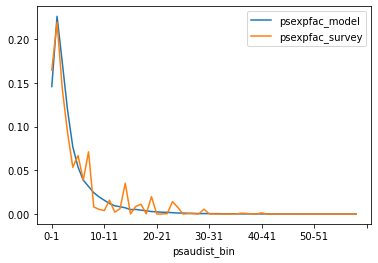

In [17]:
# Create bins
max_bin = 60
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

<AxesSubplot:xlabel='psaudist_bin'>

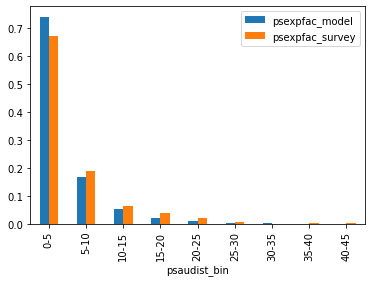

In [18]:
# Create bins
max_bin = 50
person['psaudist_bin'] = pd.cut(person['psaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person[(person['source'] == 'model') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['psaudist'] <= max_bin) & (person['psaudist'] > 0)]
df1 = df1.groupby('psaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('psaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

# School Tour Distance

### Total

In [20]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df = df[(df['pdpurp'] == 'School')]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df = df.groupby('source').sum()
pd.DataFrame(df['wt_autodist']/df['toexpfac'], columns=['School Distance (miles)'])

,School Distance (miles)
source,
model,3.667215
survey,4.277133


### By Mode

In [21]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source) & (df['pdpurp'] == 'School')]
    df1 = _df.groupby('tmodetp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('tmodetp').sum()[['toexpfac']].reset_index ()
    _df = df1.merge(df2, on='tmodetp')
    _df['commute_distance'] = _df['wt_autodist']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='tmodetp', columns='source', aggfunc='first', values='commute_distance')
df.rename(columns={'temodetp': 'Tour Mode'}, inplace=True)
df.drop(['School Bus', 'Park'], axis=0, inplace=True)
df

source,model,survey
tmodetp,,
Bike,2.569636,1.537459
HOV2,3.522687,4.754287
HOV3+,3.642029,4.325446
SOV,7.355436,5.249002
TNC,2.332774,3.352090
Transit,5.969371,6.589889
Walk,1.112619,1.041474
